## Machine Learning Engineer Nanodegree
## Capstone Project
### Talking Data Ad Tracking Challenge - from Kaggle

In this notebook, we build a predictive model to predict whether a click on an ad will lead to an app download.
The high level steps followed are:
#### 1. [Loading Packages and Data](#Section_1) <br> 2. [Data exploration, visualization, and cleaning](#Section_2) <br> 3. [Feature Engineering - Creation, Reduction](#Section_3) <br> 4. [Balance Dataset](#Section_4) <br> 5. [Modeling - benchmarking, feature selection, multiple models, model selection, hyper-parameter tuning](#Section_5) <br> 6. [Final Results](#Section_6)
    

Referenced: https://www.kaggle.com/nanomathias/feature-engineering-importance-testing

_________________

<a id = "Section_1"></a>
### 1. Loading Packages and Data

In [25]:
%%capture
import pandas as pd
import numpy as np
import random
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import classification_report, fbeta_score, roc_curve, roc_auc_score, auc, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
random.seed(20)
import gc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.grid_search import GridSearchCV
import lightgbm as lgb
import xgboost as xgb
import pickle
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize, minimize_scalar
%matplotlib inline

In [26]:
sample_1m = pd.read_csv('train_1m.csv', parse_dates =  ['click_time', 'attributed_time'])
df = sample_1m.copy(deep = True)
print("The training set has", round(df.is_attributed.mean(), 3)*100, "% of positive class instances") 
df.dtypes

The training set has 0.3 % of positive class instances


ip                          int64
app                         int64
device                      int64
os                          int64
channel                     int64
click_time         datetime64[ns]
attributed_time    datetime64[ns]
is_attributed               int64
dtype: object

______________

<a id = "Section_2"></a>
### 2. Data Exploration and Visualization

In [27]:
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,34457,12,1,13,140,2017-11-07 06:38:07,NaT,0
1,23358,15,1,19,265,2017-11-07 01:25:53,NaT,0
2,194296,14,1,18,123,2017-11-06 16:04:50,NaT,0
3,209539,2,1,8,477,2017-11-07 12:58:09,NaT,0
4,90904,26,1,19,121,2017-11-06 17:18:31,NaT,0


In [28]:
## Number of unique valued for each column in the dataframe
[{i: df[i].nunique()} for i in df.columns]

[{'ip': 72676},
 {'app': 273},
 {'device': 394},
 {'os': 195},
 {'channel': 163},
 {'click_time': 142269},
 {'attributed_time': 2498},
 {'is_attributed': 2}]

In [29]:
## number of samples (clicks) which have been attributed
df.is_attributed.sum()

2532

In [30]:
## Check for missing values
df.isna().sum()

ip                      0
app                     0
device                  0
os                      0
channel                 0
click_time              0
attributed_time    997468
is_attributed           0
dtype: int64

#### Exploring feature: 'attributed_time'

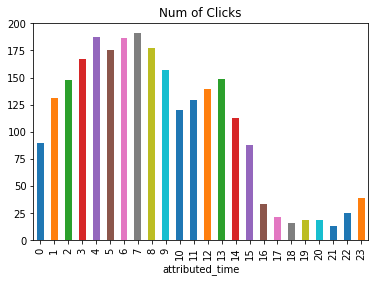

In [31]:
## Explore only the attributed clicks, compute time diff between click and attribution, plot the attributed time distribution
att_time_explore_df = df[df.attributed_time.notnull()]
att_time_explore_df['time_diff'] = (att_time_explore_df.attributed_time - att_time_explore_df.click_time).dt.seconds/60
att_time_explore_df.groupby(att_time_explore_df.attributed_time.dt.hour)['is_attributed'].size().\
plot(kind = 'bar', title = 'Num of Clicks');

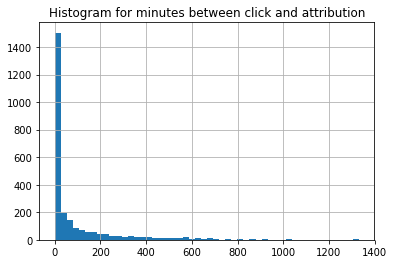

In [32]:
## Plot time diff
att_time_explore_df.time_diff.hist(bins = 50)
plt.title('Histogram for minutes between click and attribution');

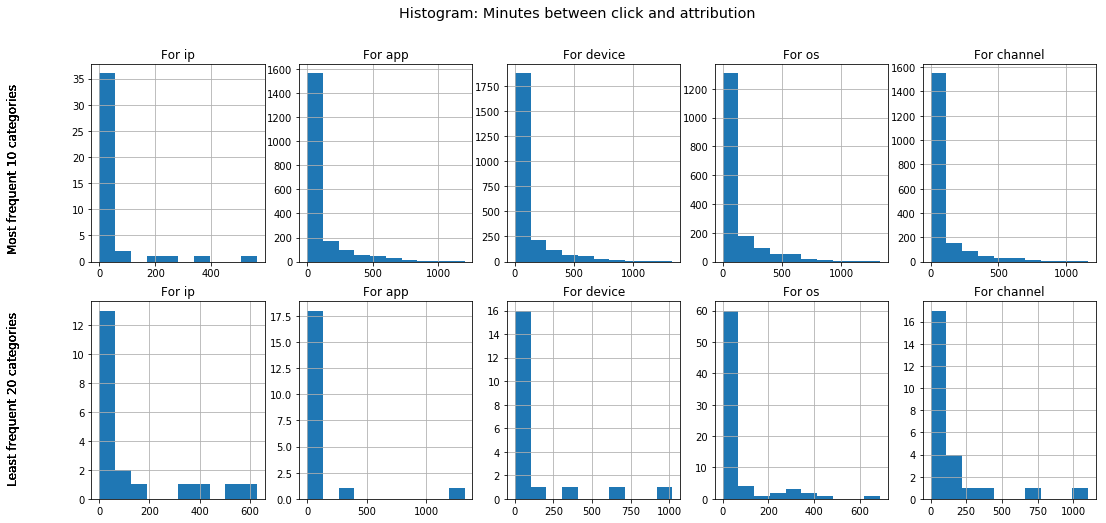

In [33]:
## Histogram for the main features - for time between click and attribution
fig, axs = plt.subplots(nrows = 2, ncols=5, figsize=(18, 8))
fig.suptitle('Histogram: Minutes between click and attribution', size = 'x-large')
for i, col in enumerate(['ip', 'app', 'device', 'os', 'channel']):
    top_n = att_time_explore_df[att_time_explore_df[col].\
                                isin(list(att_time_explore_df[col].value_counts().head(10).index))]\
                                [[col,'time_diff', 'is_attributed']]
    top_n.time_diff.hist(bins = 10, ax = axs[0, i])
    axs[0,i].set_title('For {}'.format(col))
    bottom_n = att_time_explore_df[att_time_explore_df[col].\
                                isin(list(att_time_explore_df[col].value_counts().tail(20).index))]\
    [[col,'time_diff', 'is_attributed']]
    bottom_n.time_diff.hist(bins = 10, ax = axs[1, i])
    axs[1,i].set_title('For {}'.format(col))
    fig.text(0.06, 0.3, 'Least frequent 20 categories', ha='left', va='center', rotation='vertical', size = 'large')
    fig.text(0.06, 0.7, 'Most frequent 10 categories', ha='left', va='center', rotation='vertical' , size = 'large')

**_We do not see anything unexpected or interesting with this feature so we discard it._**

In [34]:
df.drop('attributed_time', axis = 1, inplace = True, errors = 'ignore')
df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,34457,12,1,13,140,2017-11-07 06:38:07,0
1,23358,15,1,19,265,2017-11-07 01:25:53,0
2,194296,14,1,18,123,2017-11-06 16:04:50,0
3,209539,2,1,8,477,2017-11-07 12:58:09,0
4,90904,26,1,19,121,2017-11-06 17:18:31,0


**_Create a click-hour feature._**

In [35]:
df['click_hour'] = df.click_time.dt.hour

				Most frequently occurring values for clicks
		Note: The green bars indicate those values which have above average attribution


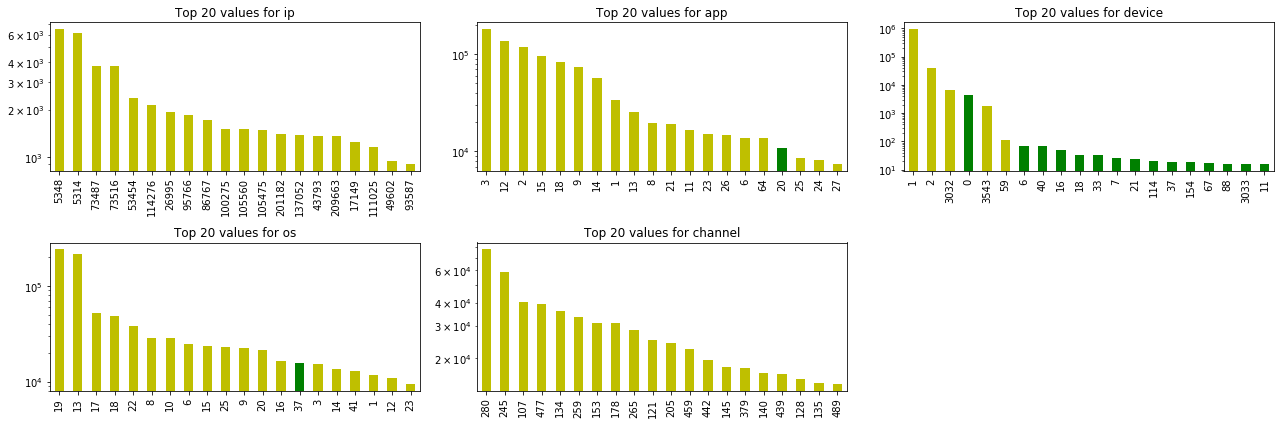

In [36]:
print('\t\t\t\tMost frequently occurring values for clicks')
print('\t\tNote: The green bars indicate those values which have above average attribution')
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(18, 6))
axs = axs.ravel()
for i, col in enumerate(['ip', 'app', 'device', 'os', 'channel']):
    ## Get the top frequency values for each column i
    top_n = df[df[col].isin(list(df[col].value_counts().head(20).index))][[col, 'is_attributed']]
    colors = []
    ## Define the color vector based on whether the proportion of attributed clicks is above average
    for j in top_n[col].value_counts().index: 
        if top_n[top_n[col] == j].is_attributed.mean() > df.is_attributed.mean():
            colors.append('g')
        else:
            colors.append('y')
    top_n.groupby(col)['is_attributed'].size().sort_values(ascending = False).\
    plot(kind = 'bar', ax = axs[i], color = colors)
    axs[i].xaxis.label.set_visible(False)
    axs[i].set_yscale('log')
    axs[i].set_title('Top 20 values for {}'.format(col))
    axs[5].axis('off');
    fig.tight_layout()

**_We see that most of the high frequency categories do not have an above average attribution rate, i.e., 0.0023_**

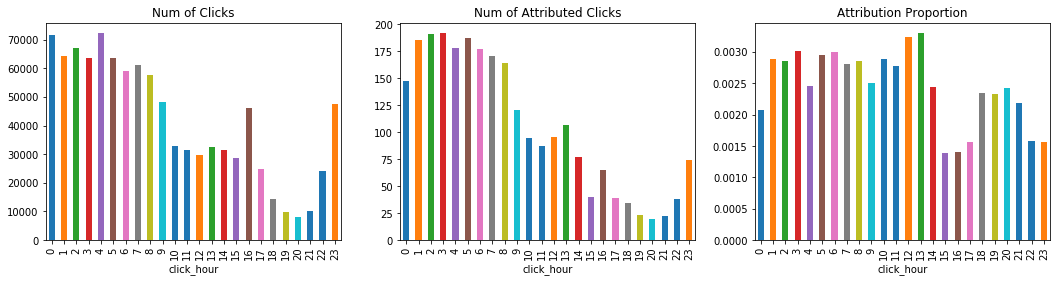

In [37]:
## Plotting for every click hour - the number of clicks, attributed clicks and also the proportion of clicks that are attributed
fig, axs = plt.subplots(ncols=3, figsize=(18, 4))
df.groupby(df.click_hour)['is_attributed'].size().plot(kind = 'bar', ax = axs[0], title = 'Num of Clicks')
df.groupby(df.click_hour)['is_attributed'].sum().plot(kind = 'bar', ax = axs[1], title = 'Num of Attributed Clicks')
df.groupby(df.click_hour)['is_attributed'].mean().plot(kind = 'bar', ax = axs[2], title = 'Attribution Proportion');

**_As expected, the click frequency drops during night time in China (UTC+7); from the third plot we see that the attribution rates are relatively higher during the day compared to at night._**

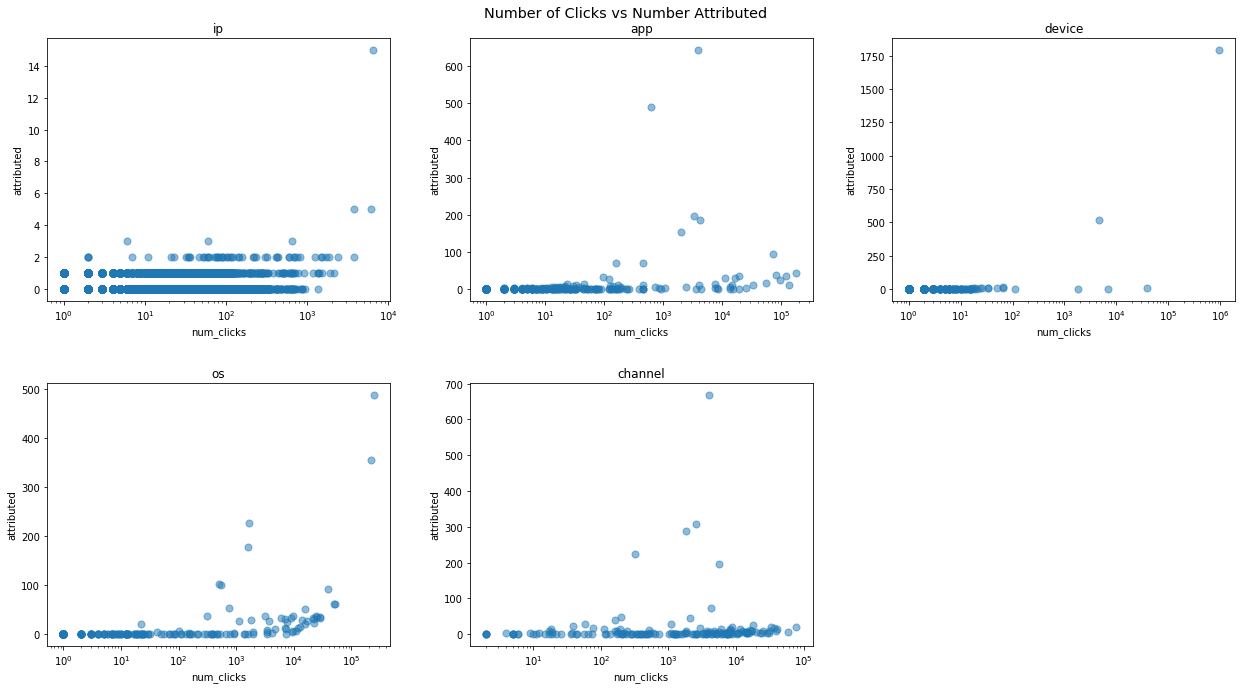

In [38]:
## Scatter plots for number of clicks vs number of attributed clicks for each of the main features in the data set
fig, axs = plt.subplots(nrows = 2, ncols=3, figsize=(18, 10))
axs = axs.ravel()
fig.suptitle('Number of Clicks vs Number Attributed', size = 'x-large')
for i, col in enumerate(['ip', 'app', 'device', 'os', 'channel']):
    df_agg = df.groupby(col).agg({'click_time': 'count','is_attributed':'sum'}).\
    rename(columns={'click_time':'num_clicks','is_attributed' : 'attributed'}).reset_index()
    df_agg.plot.scatter('num_clicks', 'attributed', logx = True, s = 50, alpha = 0.5, ax  = axs[i])
    axs[i].set_title(col)
    fig.tight_layout(pad = 3)
axs[5].axis('off');

**_The scatter plots show only a handful of values with high attribution #, which we will analyse below. Most of the IP addresses have no more than 5 attributions._**

Top 10 by clicks



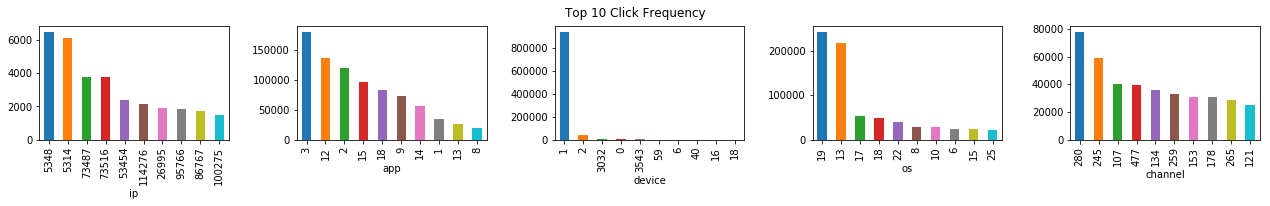

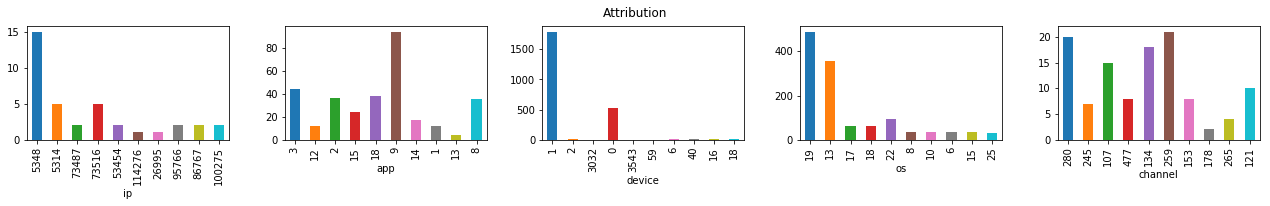

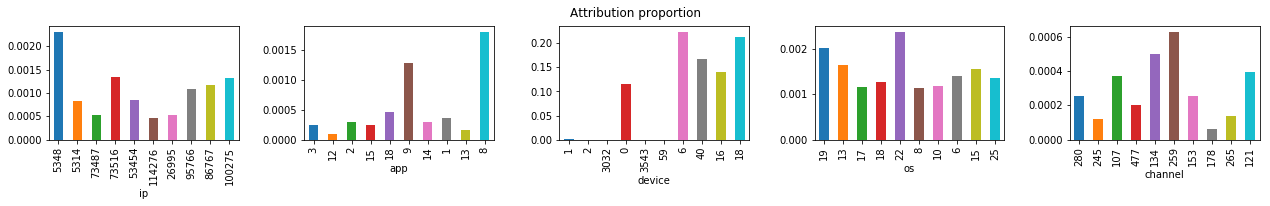

In [39]:
print('Top 10 by clicks\n')
fig, axs = plt.subplots(ncols=5, figsize=(18, 3))
fig.suptitle('Top 10 Click Frequency')
for i, col in enumerate(['ip', 'app', 'device', 'os', 'channel']):
    ## get a subset of the dataframe based on the high frequency values in each column i
    top_n = df[df[col].isin(list(df[col].value_counts().head(10).index))][[col, 'is_attributed']]
    top_n.groupby(col)['is_attributed'].size().sort_values(ascending = False).plot(kind = 'bar', ax = axs[i]);
    fig.tight_layout(pad = 2)

fig, axs = plt.subplots(ncols=5, figsize=(18, 3))
fig.suptitle('Attribution')
for i, col in enumerate(['ip', 'app', 'device', 'os', 'channel']):
    top_n = list(df[col].value_counts().head(10).index)
    top_n_df = df[df[col].isin(top_n)].groupby(col).is_attributed.sum().rename('attr_sum').reset_index()
    top_n_df[col] = pd.Categorical(top_n_df[col], categories=top_n, ordered=True)
    top_n_df.sort_values(by = col).plot.bar(x = col, y = 'attr_sum', ax = axs[i], legend = False);    
    fig.tight_layout(pad = 2)

fig, axs = plt.subplots(ncols=5, figsize=(18, 3))
fig.suptitle('Attribution proportion')
for i, col in enumerate(['ip', 'app', 'device', 'os', 'channel']):
    top_n = list(df[col].value_counts().head(10).index)
    top_n_df = df[df[col].isin(top_n)].groupby(col).is_attributed.mean().rename('attr_mean').reset_index()
    top_n_df[col] = pd.Categorical(top_n_df[col], categories=top_n, ordered=True)
    top_n_df.sort_values(by = col).plot.bar(x = col, y = 'attr_mean', ax = axs[i], legend = False);
    fig.tight_layout(pad = 2)

**_Interesting observations for top 10 values by click frequency:_** <br>
**ip**: There are two dominating ip's following which the frequency gradually drops. <br>
**app**: have more attributions, possibly indicating the popularity of apps <br>
**device**: there is a single dominating device type with below average attribution. However, devices 6, 40, 16, 18 have greater proportions. <br>
**os**: there are two dominating OS types 19, 13, but most have similar proportions for attribution.<br>
**channel**: The attribution proportions are low indicating that channels with high click frequency do not necessarily have the best attribution. <br>

Top 10 by Attribution



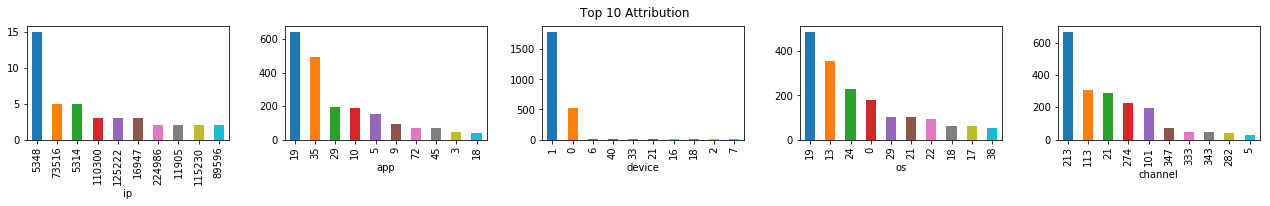

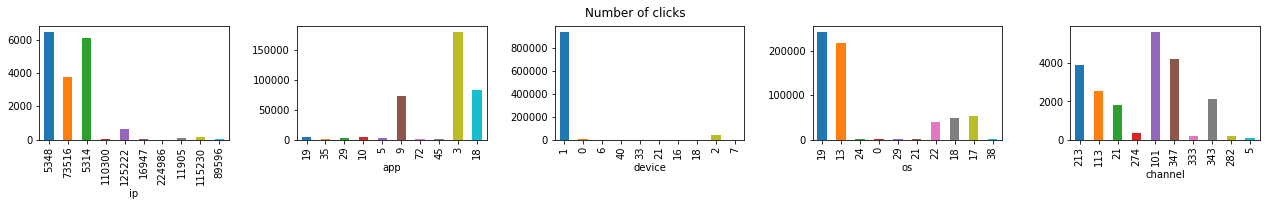

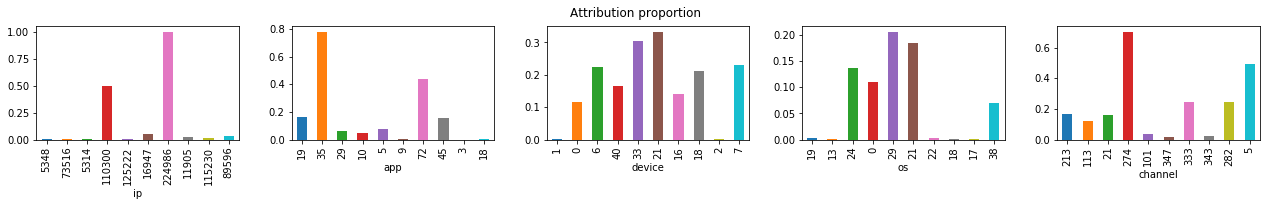

In [40]:
print('Top 10 by Attribution\n')
fig, axs = plt.subplots(ncols=5, figsize=(18, 3))
fig.suptitle('Top 10 Attribution')
for i, col in enumerate(['ip', 'app', 'device', 'os', 'channel']):
    df.groupby(col)['is_attributed'].sum().sort_values(ascending = False).head(10).plot(kind = 'bar', ax = axs[i]);
    fig.tight_layout(pad = 2)
    
fig, axs = plt.subplots(ncols=5, figsize=(18, 3))
fig.suptitle('Number of clicks')
for i, col in enumerate(['ip', 'app', 'device', 'os', 'channel']):
    top_n = list(df.groupby(col)['is_attributed'].sum().sort_values(ascending = False).head(10).index)
    top_n_df = df[df[col].isin(top_n)].groupby(col).size().rename('clicks').reset_index()
    top_n_df[col] = pd.Categorical(top_n_df[col], categories=top_n, ordered=True)
    top_n_df.sort_values(by = col).plot.bar(x = col, y = 'clicks', ax = axs[i], legend = False);    
    fig.tight_layout(pad = 2)
    
fig, axs = plt.subplots(ncols=5, figsize=(18, 3))
fig.suptitle('Attribution proportion')
for i, col in enumerate(['ip', 'app', 'device', 'os', 'channel']):
    top_n = list(df.groupby(col)['is_attributed'].sum().sort_values(ascending = False).head(10).index)
    top_n_df = df[df[col].isin(top_n)].groupby(col)['is_attributed'].mean().rename('attr_mean').reset_index()
    top_n_df[col] = pd.Categorical(top_n_df[col], categories=top_n, ordered=True)
    top_n_df.sort_values(by = col).plot.bar(x = col, y = 'attr_mean', ax = axs[i], legend = False); 
    fig.tight_layout(pad = 2)

**_For the top 10 values by attribution numbers for each feature:_** <br>
**ip**: There's a gradual decline in the attribution numbers for these ip's; 5348, 5314, 73516 stand out for click traffic, and 15195 for a very high attribution proportion. <br>
**app**: The top attributed apps have very few clicks, again indicating the popularity of apps and a predisposition to convert easily. Two of them are above average. <br>
**device**: there is a steep decline for attribution numbers for device. However, the proportions are higher than average for most. <br>
**os**: Most of the attributions come from 4 OS' and OS 29 has the highest attribution proportion.<br>
**channel**: Most of the top attributed channels also have a reasonably sized click traffic, but the most striking finding is the potency(attribution proportion) of channel 274 and 5 for attribution.<br>

In [41]:
gc.collect()

42517

______________

<a id = "Section_3"></a>
### 3. Feature Engineering

Before going ahead with modeling, we will create numeric features derived from the mostly categorical data available to us.
We will create the following features for each row: <br>
1. Counts for each of 5 categorical features and click_hour
2. Proportion of the clicks for each of the unique values in each feature which are attributed, i.e., mean of 'is_attributed' feature. (For the test data, this would be populated through relevant joins, and where there are missing values, filled with mean.
<br><br> The next two types of features engineered were inspired from the reference link stated above.
3. Counts for unique combinations of the base attributes.
4. Number of distict values for a unique combinations of base attributes

    

In [42]:
df.shape

(1000000, 8)

#### Feature Creation

In [43]:
for i, col in enumerate(['ip', 'app', 'device', 'os', 'channel', 'click_hour']):
    ## number of rows for each value
    gp = df.groupby(col).size().rename('ct_'+col).reset_index()
    df = df.merge(gp, on= col, how = 'left')
    ## proportion of clicks that are attributed for each value
    gp = df.groupby(col)['is_attributed'].mean().rename('avg_atr_'+col).reset_index()
    df = df.merge(gp, on= col, how = 'left')
df.shape    

(1000000, 20)

In [44]:
other_aggregations = [
    
# Row counts for unique combinations of base attributes(ip, app, device, os, channel, click_hour)
    # select can be any other column; we simply want to know the size of the group
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'}, 
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['ip', 'os'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['ip','click_hour'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['ip','channel'], 'select': 'device', 'agg': 'count'},
    {'groupby': ['ip','app','channel'], 'select': 'click_hour', 'agg': 'count'}, 
    {'groupby': ['ip','app','click_hour'], 'select': 'channel', 'agg': 'count'},
# Number of distict values for a unique combinations of base attributes
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'click_hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'} 
]

def create_features(df):
    for item in other_aggregations:
        agg_name = item['agg']
        new_feature = '{}_{}_{}'.format('_'.join(item['groupby']), agg_name, item['select'])
        all_features = list(set(item['groupby'] + [item['select']]))
        gp = df[all_features].groupby(item['groupby'])[item['select']].\
            agg(item['agg']).reset_index().rename(index=str, columns={item['select']: new_feature})
        df = df.merge(gp, on=item['groupby'], how='left')
        del gp
        gc.collect()
    return df


In [45]:
df = create_features(df)
df.shape

(1000000, 34)

**_Load test data and create same set of features as in training data set:_**

In [46]:
## Reading in the test data set
test_df = pd.read_csv('test_500k.csv', parse_dates =  ['click_time', 'attributed_time'])
test_df.drop('attributed_time', axis = 1, inplace = True, errors = 'ignore')
test_df['click_hour'] = test_df.click_time.dt.hour

## Creating the first set of features for the test data set
for i, col in enumerate(['ip', 'app', 'device', 'os', 'channel', 'click_hour']):
    df_to_merge = df[[col, 'ct_'+col, 'avg_atr_'+col]].drop_duplicates()
    test_df = test_df.merge(df_to_merge, on= col, how = 'left')

## Creating the other_aggregation features
test_df = create_features(test_df)

In [47]:
test_df.fillna(test_df.mean(), inplace = True)

In [48]:
features = list(df.columns.drop(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed'], errors= 'ignore'))
len(features)

27

#### Feature reduction

We remove the highly correlated features, i.e., having correlation coefficient > 0.9 or < -0.9 

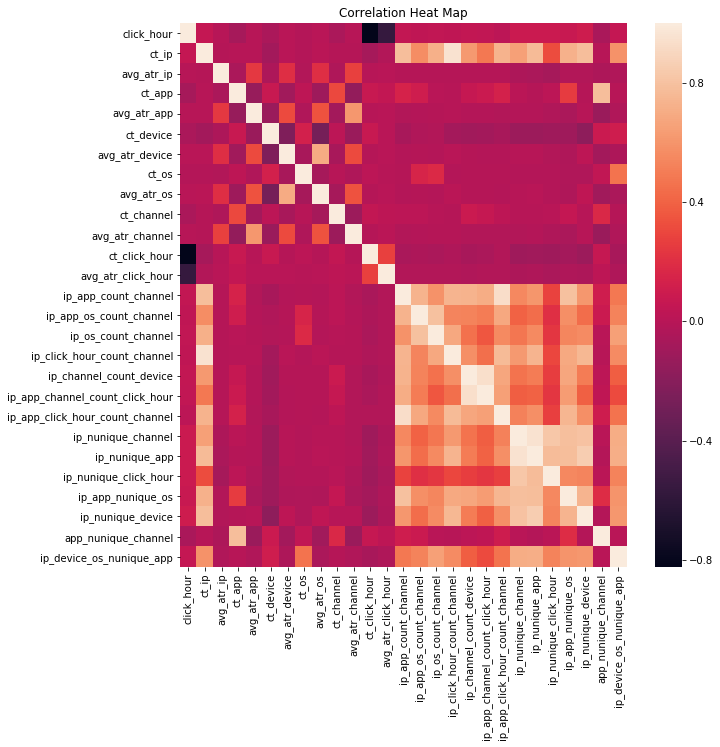

In [49]:
fig, ax = plt.subplots(figsize = (10,10))
corr = df[features].corr()
sns.heatmap(corr);
ax.set_title('Correlation Heat Map');

In [50]:
## Get the correlation matrix and remove columns that have high correlation coefficient
corr_matrix = df[features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

In [51]:
to_drop

['ip_click_hour_count_channel',
 'ip_app_channel_count_click_hour',
 'ip_app_click_hour_count_channel',
 'ip_nunique_app']

In [52]:
## reducing the feature set
features = [x for x in features if x not in to_drop]
len(features)

23

In [53]:
df = df[features + ['is_attributed']].drop_duplicates()
df.fillna(df.mean(), inplace=True)

______________

<a id = "Section_4"></a>
### 4. Balance Data Set
We use SMOTE to create a balanced dataset and then again take a sample of a million rows as started.

In [54]:
## Perform the SMOTE over-sampling
sm = SMOTE(ratio = 'minority', random_state=100)
X_o, y_o = sm.fit_sample(df[features], df.is_attributed)

## Take a random sample of 1 million records from this
df = pd.DataFrame(pd.concat([pd.DataFrame(X_o), pd.Series(y_o)], axis = 1))
df.columns = features + ['is_attributed']
df = df.sample(1000000, random_state=100)
print("The training data set has shape:", df.shape)
print("After applying SMOTE, the target class distribution is as follows:\n", df.is_attributed.value_counts())

The training data set has shape: (1000000, 24)
After applying SMOTE, the target class distribution is as follows:
 0    500321
1    499679
Name: is_attributed, dtype: int64


______________

<a id = "Section_5"></a>
### 5. Modeling

In [55]:
## function to compute the various performance metrics on the test set for a model
def pred_metrics(y_test, y_pred, algo):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
    metrics[algo] = dict.fromkeys(['AUC', 'F1', 'F2', 'F.5'])
    metrics[algo]['AUC'] = (auc(fpr, tpr).round(3))
    metrics[algo]['F1'] = (fbeta_score(y_test, y_pred.round(), beta = 1).round(3)) 
    metrics[algo]['F2'] = (fbeta_score(y_test, y_pred.round(), beta = 2).round(3))
    metrics[algo]['F.5'] = (fbeta_score(y_test, y_pred.round(), beta = 0.5).round(3))
    print(algo, " AUC:", auc(fpr, tpr).round(3))
    
## Function to computed the fpr, tpr and then plot the ROC curve on top of the previous ROC curves
def plot_roc(clf, algo):
    global roc 
    try:
        fpr, tpr, _ = roc_curve(test_df.is_attributed, clf.predict_proba(test_df[features])[:, 1])
    except:
    ## Handle for xgb and lgb because they do not have predict_proba   
        if (str(type(clf)) == "<class 'xgboost.core.Booster'>"):
            y_pred = clf.predict(xgb.DMatrix(test_df[features]))
            fpr, tpr, _ = roc_curve(test_df.is_attributed, y_pred)
        elif (str(type(clf)) == "<class 'lightgbm.basic.Booster'>"):
            fpr, tpr, _ = roc_curve(test_df.is_attributed, clf.predict(test_df[features]))
    ## Append fpr, tpr to the roc data frame
    roc = roc.append(pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'lgnd': algo}))

    fig, axs = plt.subplots(ncols = 1, figsize = (6, 6))
    axs = plt.subplot(111)
    z = 1
    for name, i in roc.groupby('lgnd'):
        plt.plot(i.fpr, i.tpr, label=name, linewidth = 2.5, zorder = z)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Test Data ROC')
        plt.legend(loc = 4, fontsize = 12);
        z = z+1
    fig.tight_layout(w_pad=5)
       
## function to save a fitted model
def save_model(clf, algo):
    f = open(algo+'.pkl', 'wb')
    pickle.dump(clf, f)
    f.close()
    
## function to get feature importances and plot the same
def feat_importance(clf):
    feat_imp = pd.DataFrame(clf.feature_importances_, columns= ['feat_import'], index= features)
    feat_imp.sort_values(by = 'feat_import', axis = 0, inplace = True, ascending = False)
    feat_imp['cumul_imp'] = feat_imp.feat_import.cumsum()
    feat_imp.feat_import.plot(kind = 'bar', figsize=(10, 6), title = 'Feature Importance');
    return feat_imp

In [56]:
## roc is used to store the fpr's and tpr's for plotting the ROCs
## metrics dict stores the metrics for all the models
roc = pd.DataFrame()
metrics = {}

#### Feature selection using AdaBoost

In [57]:
%%time
# ~10min
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), algorithm="SAMME", n_estimators=50, random_state=100)
ada_model = ada.fit(df[features], df.is_attributed)

Wall time: 14min 45s


adaboost  AUC: 0.666


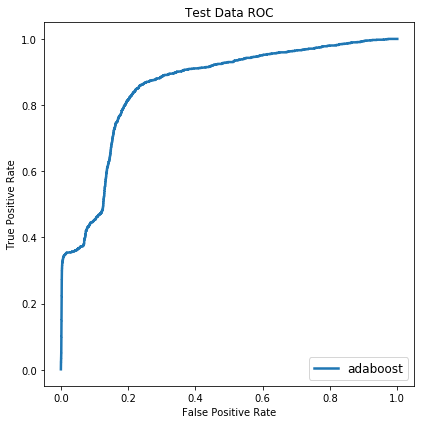

In [58]:
## Save the model as .pkl file, store the metrics, and plot the ROC curve
save_model(ada_model, 'adaboost')
pred_metrics(test_df.is_attributed, ada_model.predict(test_df[features]), 'adaboost')
plot_roc(ada_model, 'adaboost')

#### Feature importance

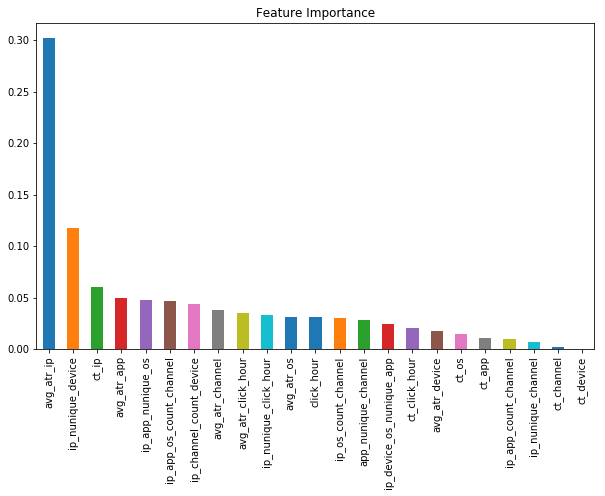

In [59]:
feat_imp = feat_importance(ada_model)

**_We reduce the feature set to include only those with feature importance greater than 0.025. <br>
We also remove the first feature as it is likely associated with over-fitting._**

In [60]:
## final feature selection based on the feature importance seen above
features = list(feat_imp[(feat_imp.feat_import >= 0.025) & (feat_imp.feat_import < 0.25)].index)

In [61]:
df[features].shape

(1000000, 13)

#### Benchmarking - Random Forest

In [62]:
roc = pd.DataFrame()
metrics = {}

In [63]:
%%time
rf = RandomForestClassifier(random_state=100)
rf_model = rf.fit(df[features], df.is_attributed)

Wall time: 1min 28s


benchmark_rf  AUC: 0.823


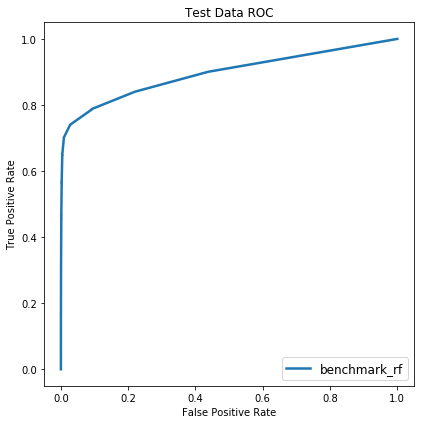

In [64]:
save_model(rf_model, 'benchmark_rf')
pred_metrics(test_df.is_attributed, rf_model.predict(test_df[features]), 'benchmark_rf')
plot_roc(rf_model, 'benchmark_rf')

#### AdaBoost

In [65]:
%%time
# ~10min
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), algorithm="SAMME", n_estimators=50, random_state=100)
bdt_model = bdt.fit(df[features], df.is_attributed)

Wall time: 9min 13s


adaboost  AUC: 0.899


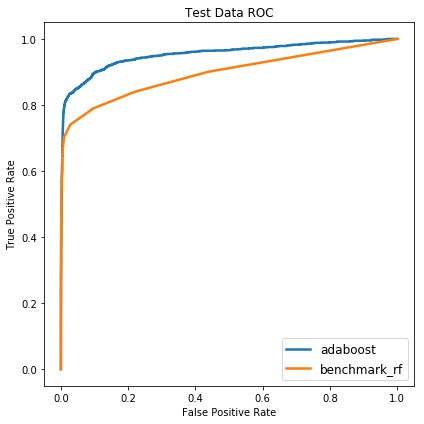

In [66]:
save_model(bdt_model, 'adaboost')
pred_metrics(test_df.is_attributed, bdt_model.predict(test_df[features]), 'adaboost')
plot_roc(bdt_model, 'adaboost')

#### Logistic Regression

In [67]:
%%time
lr_model = LogisticRegression(random_state=100)
lr_model.fit(df[features], df.is_attributed)

Wall time: 1min 57s


log_reg  AUC: 0.908


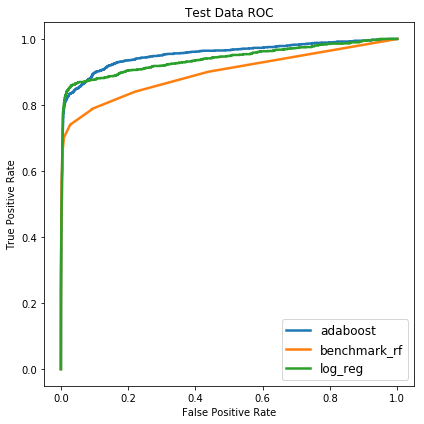

In [68]:
save_model(lr_model, 'log_reg')
pred_metrics(test_df.is_attributed, lr_model.predict(test_df[features]), 'log_reg')
plot_roc(lr_model, 'log_reg')

#### XGBoost

In [69]:
%%time
%%capture
X_train, X_test, y_train, y_test = train_test_split(df[features], df.is_attributed, test_size=0.33, random_state=42)
m_df_train = xgb.DMatrix(X_train, label=y_train)
m_df_eval = xgb.DMatrix(X_test, label=y_test)
param = {'max_depth': 2, 'eta': 1, 'silent': 1,
         'objective': 'binary:logistic' , 'scale_pos_weight': 90,
         'nthread': 4, 'eval_metric': 'auc'
        }
evallist = [(m_df_eval, 'eval'), (m_df_train, 'train')]
num_round = 10
xgb_model = xgb.train(param, m_df_train, num_round, evallist)

Wall time: 5.83 s


xgb  AUC: 0.935


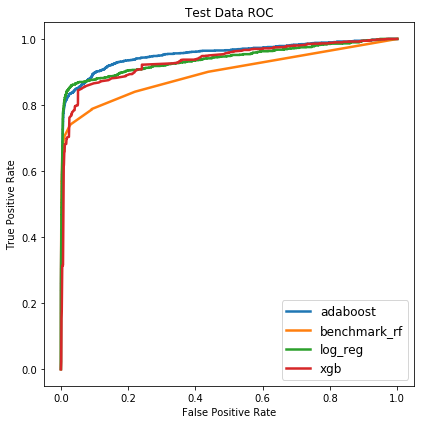

In [70]:
save_model(xgb_model, 'xgb')
y_pred = xgb_model.predict(xgb.DMatrix(test_df[features]))
pred_metrics(test_df.is_attributed, y_pred, 'xgb')
plot_roc(xgb_model, 'xgb')

#### Light GBM

In [71]:
%%time
%%capture
X_train, X_test, y_train, y_test = train_test_split(df[features], df.is_attributed, test_size=0.33, random_state=42)
m_df_train = lgb.Dataset(X_train, label=y_train)
m_df_eval = lgb.Dataset(X_test, reference=m_df_train)
num_round = 10
param = {'num_leaves':31, 'num_trees':100, 'objective':'binary', 'metric': 'auc', 'scale_pos_weight': 120}
lgb_model = lgb.train(param, m_df_train, num_round, valid_sets=[m_df_eval]);

Wall time: 17 s


lgb  AUC: 0.925


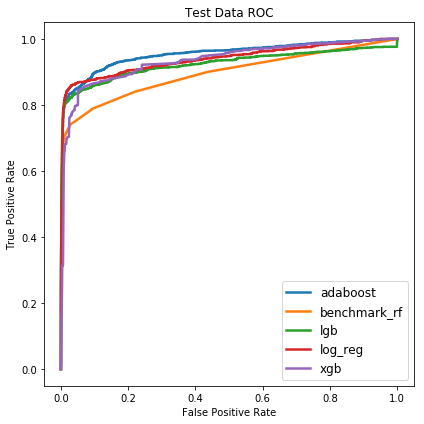

In [72]:
save_model(lgb_model, 'lgb')
pred_metrics(test_df.is_attributed, lgb_model.predict(test_df[features]), 'lgb')
plot_roc(lgb_model, 'lgb')

#### Model Selection

In [73]:
pd.DataFrame(metrics)

,adaboost,benchmark_rf,lgb,log_reg,xgb
AUC,0.899,0.823,0.925,0.908,0.935
F.5,0.150,0.321,0.037,0.150,0.006
F1,0.216,0.396,0.058,0.216,0.009
F2,0.386,0.517,0.131,0.389,0.023


**_We see that the highest average AUC is for the xgb model and hence we carry out hyperparameter tuning for this model using Grid Search_**

In [74]:
gc.collect()

24619

#### Hyper parameter tuning using grid search

In [53]:
%%time
## The following cell takes ~30 min to run. Output from the cell is stored in 'grid_xgb_final.pkl'.
## To save time, we can skip running this cell and load the model directly in the next cell if needed.

parameters = {'nthread':[4], 
              'objective':['binary:logistic'],
              'learning_rate': [0.05, 0.1],
              'max_depth': [3, 7],
              'min_child_weight': [5, 10],
              'silent': [1],
              'subsample': [0.7, 0.9],
              'colsample_bytree': [0.6, 1.0],
              'n_estimators': [10], 
              'missing':[-999],
              'random_state': [1337] 
             }

grid_xgb = GridSearchCV(xgb.XGBClassifier(), parameters, n_jobs=5, cv= 3, scoring='roc_auc', verbose=2, refit=True)
grid_xgb.fit(df[features], df.is_attributed)

best_parameters, score, _ = max(grid_xgb.grid_scores_, key=lambda x: x[1])
print('AUC:', round(score, 3))
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

save_model(grid_xgb, 'grid_xgb_final')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done  96 out of  96 | elapsed:  8.9min finished


AUC: 0.995
colsample_bytree: 0.6
learning_rate: 0.1
max_depth: 7
min_child_weight: 10
missing: -999
n_estimators: 10
nthread: 4
objective: 'binary:logistic'
random_state: 1337
silent: 1
subsample: 0.9
Wall time: 9min 7s


In [75]:
# Run this cell if you want to skip executing the previous cell to save time
grid_xgb = pickle.load(open('grid_xgb_final.pkl', 'rb'))

In [76]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

In [77]:
sp_randint(1, 11)

In [ ]:
%%time
## The following cell takes ~30 min to run. Output from the cell is stored in 'grid_xgb_final.pkl'.
## To save time, we can skip running this cell and load the model directly in the next cell if needed.

parameters = {'nthread':[4], 
              'objective':['binary:logistic'],
              'learning_rate': sp_randint(0.03, 0.9),
              'max_depth': sp_randint(3, 11),
              'min_child_weight': sp_randint(3, 11),
              'silent': [1],
              'subsample': sp_randint(0.3, 1),
              'colsample_bytree': sp_randint(0.3, 1),
              'n_estimators': [10], 
              'missing':[-999],
              'random_state': [1337] 
             }

# param_dist = {"max_depth": [3, None],
#               "max_features": sp_randint(3, 10),
#               "min_samples_split": sp_randint(2, 11),
#               "min_samples_leaf": sp_randint(1, 11),
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=parameters,
                                   n_iter=n_iter_search)

random_search.fit(df[features], df.is_attributed)

In [53]:
best_parameters, score, _ = max(random_search.grid_scores_, key=lambda x: x[1])
print('AUC:', round(score, 3))
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

save_model(grid_xgb, 'grid_xgb_final')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done  96 out of  96 | elapsed:  8.9min finished


AUC: 0.995
colsample_bytree: 0.6
learning_rate: 0.1
max_depth: 7
min_child_weight: 10
missing: -999
n_estimators: 10
nthread: 4
objective: 'binary:logistic'
random_state: 1337
silent: 1
subsample: 0.9
Wall time: 9min 7s


Grid-XGB  AUC: 0.954


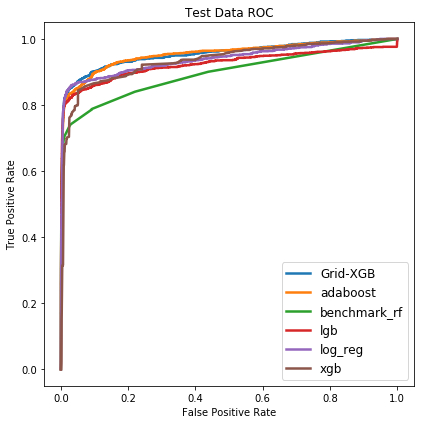

In [55]:
y_pred = grid_xgb.predict_proba(test_df[features])[:,1]
pred_metrics(test_df.is_attributed, y_pred, 'Grid-XGB')
plot_roc(grid_xgb, 'Grid-XGB')

In [56]:
grid_xgb_best = grid_xgb.best_estimator_

In [57]:
grid_xgb_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=10, missing=-999, n_estimators=10,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=1337,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.9)

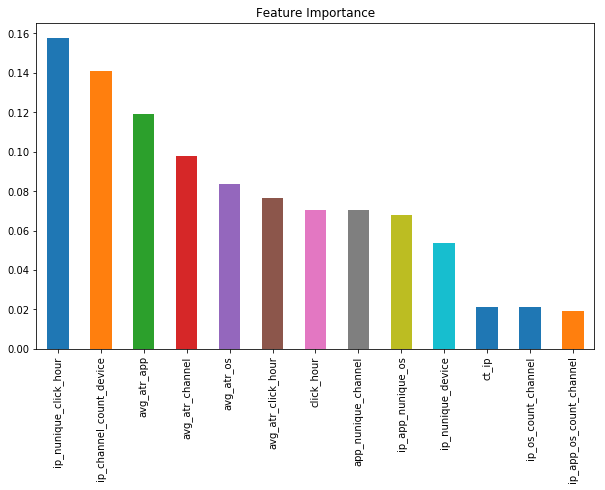

In [58]:
feat_imp = feat_importance(grid_xgb_best)

#### Best Threshold

In [59]:
## Objective functions to be minimized for value of x which is the prediction probability threshold
## Since we want to maximize F score, we multiply the min function by -1.

## Weigh precision and recall equally 
f1_score = lambda x, y: fbeta_score(test_df.is_attributed, np.where(y_pred > x, 1, 0), beta = 1)*-1
## Weigh recall higher than precision
f2_score = lambda x, y: fbeta_score(test_df.is_attributed, np.where(y_pred > x, 1, 0), beta = 2)*-1
## Weigh precision higher than recall
f5_score = lambda x, y: fbeta_score(test_df.is_attributed, np.where(y_pred > x, 1, 0), beta = 0.5)*-1

cutoffs = range(0, 2)

## Minimization results stored
res = minimize_scalar(f1_score, bounds=(0, 1), args = (cutoffs), method='bounded')
res2 = minimize_scalar(f2_score, bounds=(0, 1), args = (cutoffs), method='bounded')
res5 = minimize_scalar(f5_score, bounds=(0, 1), args = (cutoffs), method='bounded')

In [60]:
print('The optimal threshold values for best F1, F2 and F.5 score are {}, {}, {} respectively.'\
      .format(round(res.x, 3), round(res2.x, 3), round(res5.x, 3)))

The optimal threshold values for best F1, F2 and F.5 score are 0.735, 0.735, 0.741 respectively.


In [61]:
print(res, res2, res5, sep='\n\n')

     fun: -0.42673770888835066
 message: 'Solution found.'
    nfev: 19
  status: 0
 success: True
       x: 0.7353401626475278

     fun: -0.5573832721751233
 message: 'Solution found.'
    nfev: 21
  status: 0
 success: True
       x: 0.735255525149787

     fun: -0.35103437041863494
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 0.7405745046853366


**_For now, we want to optimize for the F1 score because we want to give precision and recall equal importance._** <br>
**_Hence, we choose the cutoff of 0.735._**

______________

<a id = "Section_6"></a>
### 6. Final results

In [62]:
print("Below are the metrics for all the models created.")
pd.DataFrame(metrics)

Below are the metrics for all the models created.


,Grid-XGB,adaboost,benchmark_rf,lgb,log_reg,xgb
AUC,0.954,0.899,0.823,0.925,0.908,0.935
F.5,0.157,0.150,0.321,0.037,0.150,0.006
F1,0.225,0.216,0.396,0.058,0.216,0.009
F2,0.400,0.386,0.517,0.131,0.389,0.023


**_The tuned Grid XGB model's ROC AUC is 13.1 percentage points higher than the benchmark random forest model._**

**_Detailed comparison of metrics for the benchmark model vs the final XGBoost model on the test data set:_**

In [63]:
Actual = test_df.is_attributed.rename('Actual')

## Benchmark model
Predicted_rf = rf_model.predict(test_df[features])
print('Benchmark Model\nAccuracy: {} %'.format(round(accuracy_score(Actual, Predicted_rf)*100, 3)))
print('F1 score:', round(fbeta_score(Actual, Predicted_rf, beta = 1), 3))
print(classification_report(Actual, Predicted_rf))
display(pd.crosstab(Actual, Predicted_rf, colnames=['Predicted'], margins = True))

## Final model with optimal threshold
y_pred = grid_xgb_best.predict_proba(test_df[features])[:,1]
Predicted_xgb = (y_pred >= res.x).astype(int)
print('\nFinal XGBoost Model\nAccuracy: {} %'.format(round(accuracy_score(Actual, Predicted_xgb)*100, 3)))
print('F1 score:', round(fbeta_score(Actual, Predicted_xgb, beta = 1), 3))
print(classification_report(Actual, Predicted_xgb))
display(pd.crosstab(Actual, Predicted_xgb, colnames=['Predicted'], margins = True))

Benchmark Model
Accuracy: 99.501 %
F1 score: 0.396
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    498742
          1       0.28      0.65      0.40      1258

avg / total       1.00      1.00      1.00    500000



Predicted,0,1,All
Actual,,,
0,496685,2057,498742
1,440,818,1258
All,497125,2875,500000



Final XGBoost Model
Accuracy: 99.527 %
F1 score: 0.427
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    498742
          1       0.31      0.70      0.43      1258

avg / total       1.00      1.00      1.00    500000



Predicted,0,1,All
Actual,,,
0,496752,1990,498742
1,377,881,1258
All,497129,2871,500000


**_The tuned Grid XGB model's F1 score is 3 percentage points higher than the benchmark model and its accuracy is marginally higher as well._**